In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import Birch
from sklearn.metrics import mean_squared_error, r2_score
import shap
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load and filter the data
df = pd.read_csv('kc_data.csv')
df = df[df['price'] <= 2000000]


In [3]:
# Preprocessing steps
df['date'] = pd.to_datetime(df['date'], format='%Y%m%dT%H%M%S')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month


In [4]:
# Define features and target
important_features = ['sqft_living', 'yr_built', 'grade', 'zipcode']
other_features = ['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'year', 'month', 'condition']
all_features = important_features + other_features
target = 'price'


In [5]:
# Split the data into training and testing sets
X = df[all_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# Define numerical and categorical columns
numerical_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'bathrooms', 'bedrooms', 'floors',  'grade']
categorical_cols = ['zipcode', 'waterfront', 'view', 'condition',]


In [7]:
# Preprocessing for numerical data: polynomial features and power transformation
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('power', PowerTransformer(method='yeo-johnson')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])


In [8]:
# Preprocessing for categorical data: one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [9]:
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [10]:
# Define models
models = {
    'GradientBoosting': GradientBoostingRegressor(),
    'RandomForest': RandomForestRegressor(),
    'KNN': KNeighborsRegressor()
}


In [11]:
# Create and evaluate pipelines
param_grids = {
    'GradientBoosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5, 7]
    },
    'RandomForest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [10, 20, 30]
    },
    'KNN': {
        'model__n_neighbors': range(1, 21)
    }
}

best_models = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    param_grid = param_grids[name]
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: ", grid_search.best_params_)
    print(f"Best R2 score for {name}: ", grid_search.best_score_)

Best parameters for GradientBoosting:  {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200}
Best R2 score for GradientBoosting:  0.8548761717669275
Best parameters for RandomForest:  {'model__max_depth': 30, 'model__n_estimators': 200}
Best R2 score for RandomForest:  0.7897652034603173
Best parameters for KNN:  {'model__n_neighbors': 10}
Best R2 score for KNN:  0.6087524660596948


In [12]:
# Evaluate on the test set
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"Test R2 score for {name}: ", r2_score(y_test, y_pred))

Test R2 score for GradientBoosting:  0.8507445285376835
Test R2 score for RandomForest:  0.78681299174995
Test R2 score for KNN:  0.6138374152916412


In [13]:
# BIRCH Clustering
birch = Birch(n_clusters=5)
birch.fit(preprocessor.fit_transform(X_train))
birch_labels = birch.predict(preprocessor.transform(X_train))

In [15]:
# Get feature names for numerical and categorical features
numerical_feature_names = preprocessor.transformers_[0][1].named_steps['poly'].get_feature_names_out(numerical_cols)
categorical_feature_names = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_cols)


In [16]:
# Combine feature names
feature_names = list(numerical_feature_names) + list(categorical_feature_names)

In [17]:
# Combine feature names
feature_names = list(numerical_feature_names) + list(categorical_feature_names)

# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': best_models['RandomForest'].named_steps['model'].feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance.head(20))


Feature Importance:
                       feature  importance
0                  sqft_living    0.417132
57               zipcode_98004    0.042331
9                sqft_living^2    0.034355
13        sqft_living yr_built    0.027974
143                    grade_9    0.021864
21           sqft_lot yr_built    0.020007
142                    grade_8    0.019792
141                    grade_7    0.018208
144                   grade_10    0.016346
79               zipcode_98040    0.012546
126                     view_0    0.012501
4                     yr_built    0.012100
28         sqft_above yr_built    0.011518
27    sqft_above sqft_basement    0.010664
17          sqft_living floors    0.010024
145                   grade_11    0.009764
12   sqft_living sqft_basement    0.008936
75               zipcode_98033    0.008833
41          yr_built bathrooms    0.008751
102              zipcode_98112    0.008409


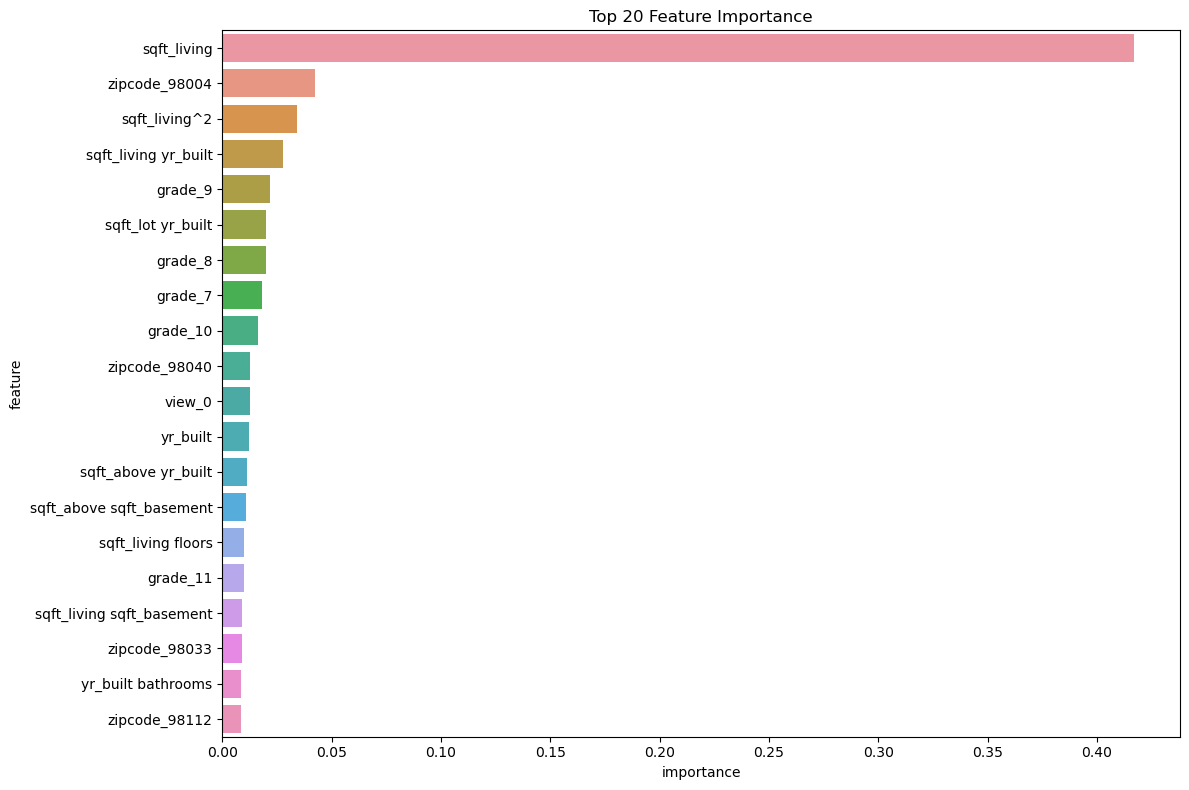

In [20]:
# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')



100%|===================| 17129/17132 [61:26<00:00]        

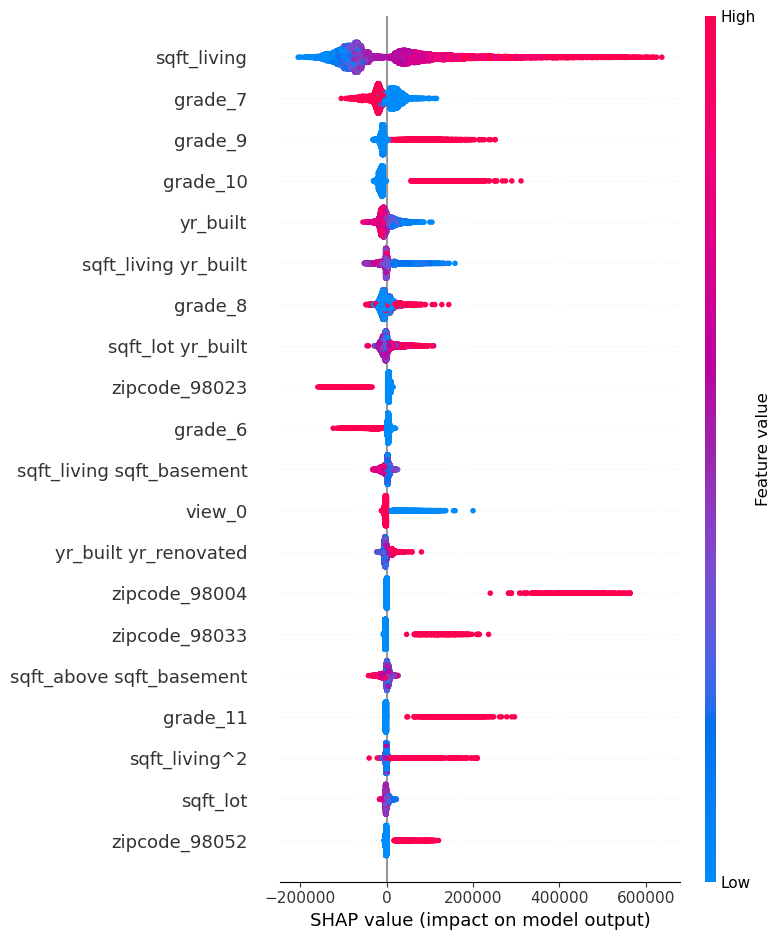

In [19]:
# SHAP values for model interpretability
#explainer = shap.Explainer(best_models['RandomForest'].named_steps['model'], preprocessor.transform(X_train))
#shap_values = explainer.shap_values(preprocessor.transform(X_train))

#shap.summary_plot(shap_values, preprocessor.transform(X_train), feature_names=feature_names)

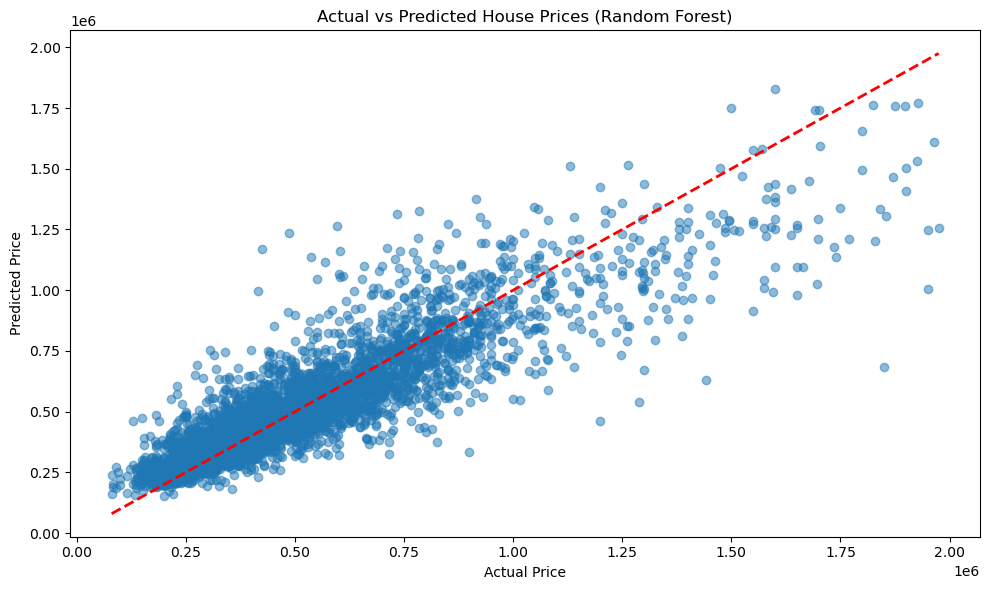

In [21]:
# Scatter plot of actual vs predicted prices (Random Forest)
y_pred_rf = best_models['RandomForest'].predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted House Prices (Random Forest)')
plt.tight_layout()
plt.savefig('actual_vs_predicted_rf.png')

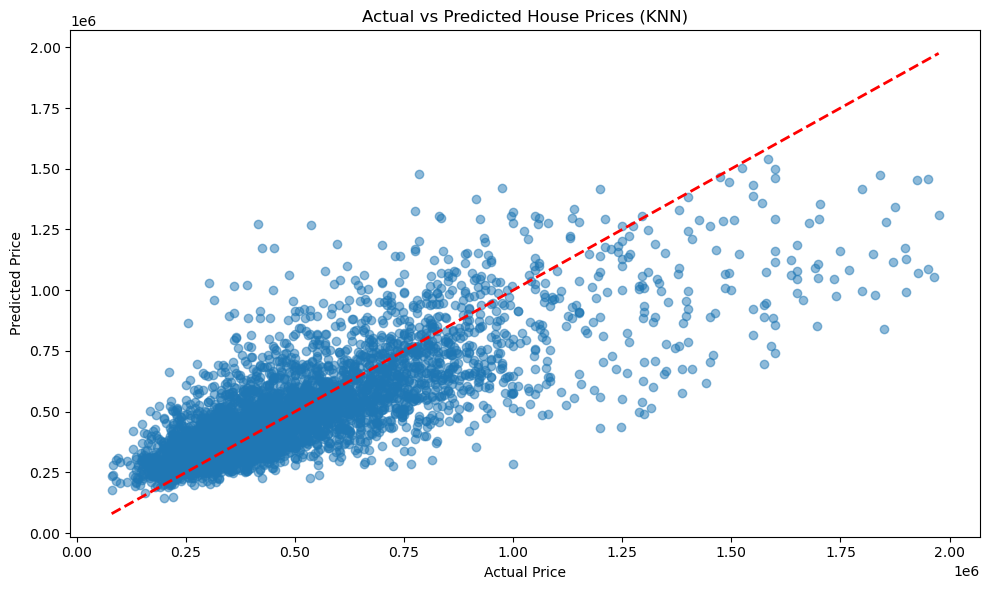

In [22]:
# Scatter plot of actual vs predicted prices (KNN)
y_pred_knn = best_models['KNN'].predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_knn, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted House Prices (KNN)')
plt.tight_layout()
plt.savefig('actual_vs_predicted_knn.png')

In [23]:
# BIRCH Clustering visualization
X_train_transformed = preprocessor.transform(X_train)
plt.figure(figsize=(10, 6))
plt.scatter(X_train_transformed[:, 0], X_train_transformed[:, 1], c=birch_labels, cmap='viridis', alpha=0.5)
plt.title('BIRCH Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.savefig('birch_clustering.png')
plt.close()


In [24]:
# Save results
results = pd.DataFrame({
    'Actual': y_test,
    'KNN Predicted': best_models['KNN'].predict(X_test),
    'RF Predicted': best_models['RandomForest'].predict(X_test)
})
results.to_csv('prediction_results.csv', index=False)
print("Analysis complete. Check the output files for results and visualizations.")

Analysis complete. Check the output files for results and visualizations.
